# Image Captioning with RNN and LSTMs

In [3]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from Model.rnn_layers import *
from Solver.captioning_solver import CaptioningSolver
from Model.rnn import CaptioningRNN
from Dataset.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from Dataset.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load MS-COCO data
We will use the Microsoft COCO dataset for captioning.

In [5]:
# Load COCO data from disk; this returns a dictionary
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

idx_to_word <type 'list'> 1004
train_captions <type 'numpy.ndarray'> (400135, 17) int32
val_captions <type 'numpy.ndarray'> (195954, 17) int32
train_image_idxs <type 'numpy.ndarray'> (400135,) int32
val_features <type 'numpy.ndarray'> (40504, 512) float32
val_image_idxs <type 'numpy.ndarray'> (195954,) int32
train_features <type 'numpy.ndarray'> (82783, 512) float32
train_urls <type 'numpy.ndarray'> (82783,) |S63
val_urls <type 'numpy.ndarray'> (40504,) |S63
word_to_idx <type 'dict'> 1004


# Train a good captioning model!
Here use RNN and LSTM model to separately train on the MS-COC data and make some tests.

# Train RNN model

In [8]:
# select 10,000 samples for training
medium_data = load_coco_data(max_train=1000)

rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

rnn_solver = CaptioningSolver(rnn_model, medium_data,
           update_rule='adam',
           num_epochs=30,
           batch_size=100,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=50,
         )

rnn_solver.train()

(Iteration 1 / 300) loss: 79.015896
(Iteration 51 / 300) loss: 38.374449
(Iteration 101 / 300) loss: 21.699017
(Iteration 151 / 300) loss: 9.051495
(Iteration 201 / 300) loss: 4.118074
(Iteration 251 / 300) loss: 1.790687


# Test the RNN model

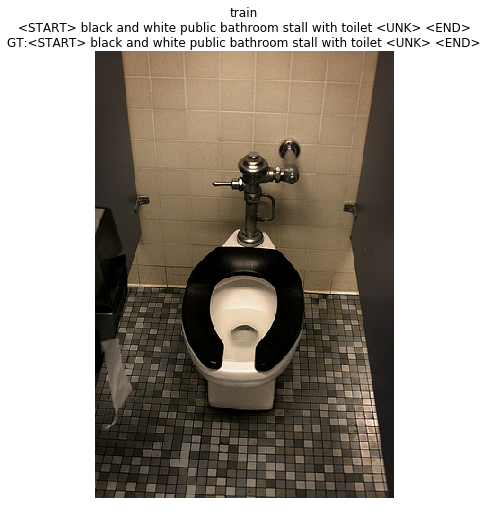

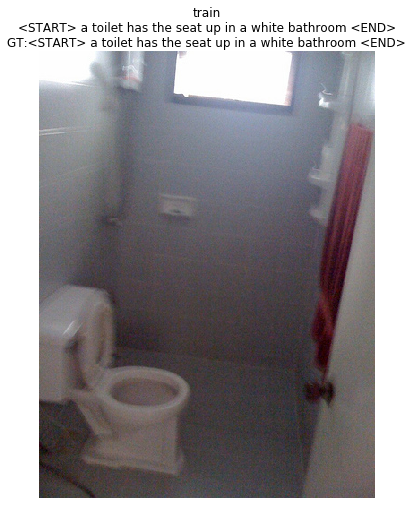

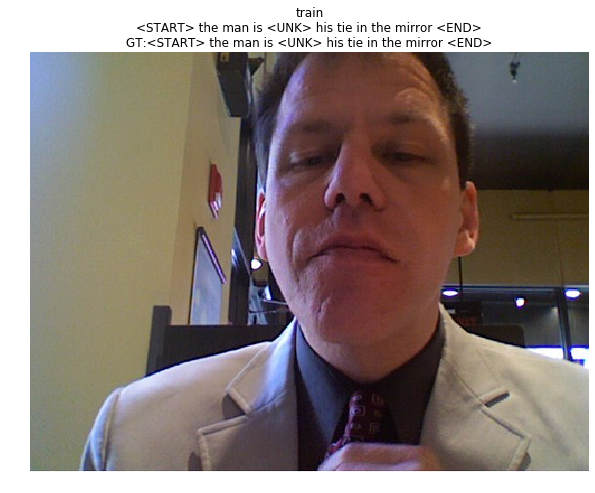

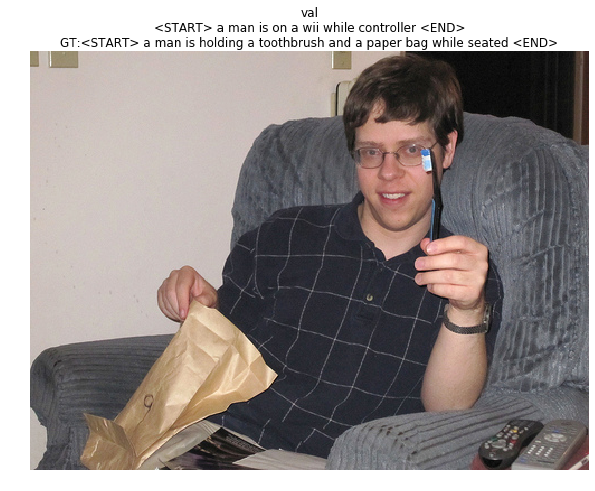

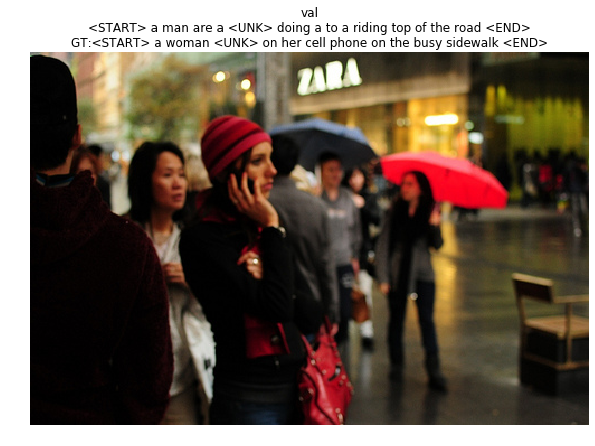

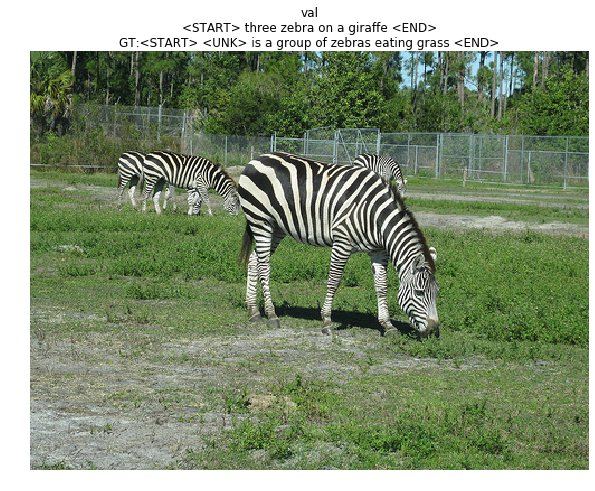

In [9]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(medium_data, split=split, batch_size=3)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = rnn_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()

# Train LSTM model

In [8]:
# select 10,000 samples for training
medium_data = load_coco_data(max_train=10000)

lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, medium_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=100,
           optim_config={
             'learning_rate': 1e-4,
           },
           lr_decay=0.995,
           verbose=True, print_every=100,
         )

lstm_solver.train()

(Iteration 1 / 5000) loss: 77.128385
(Iteration 101 / 5000) loss: 58.917318
(Iteration 201 / 5000) loss: 51.488926
(Iteration 301 / 5000) loss: 50.515870
(Iteration 401 / 5000) loss: 46.027711
(Iteration 501 / 5000) loss: 46.059278
(Iteration 601 / 5000) loss: 43.362219
(Iteration 701 / 5000) loss: 41.641952
(Iteration 801 / 5000) loss: 40.502366
(Iteration 901 / 5000) loss: 38.682114
(Iteration 1001 / 5000) loss: 37.093972
(Iteration 1101 / 5000) loss: 35.946635
(Iteration 1201 / 5000) loss: 35.787870
(Iteration 1301 / 5000) loss: 34.770208
(Iteration 1401 / 5000) loss: 33.102067
(Iteration 1501 / 5000) loss: 33.092606
(Iteration 1601 / 5000) loss: 31.554209
(Iteration 1701 / 5000) loss: 31.935388
(Iteration 1801 / 5000) loss: 30.918433
(Iteration 1901 / 5000) loss: 32.247212
(Iteration 2001 / 5000) loss: 31.091790
(Iteration 2101 / 5000) loss: 30.168697
(Iteration 2201 / 5000) loss: 29.280234
(Iteration 2301 / 5000) loss: 29.374516
(Iteration 2401 / 5000) loss: 29.693416
(Iteration 2

# Test the LSTM model

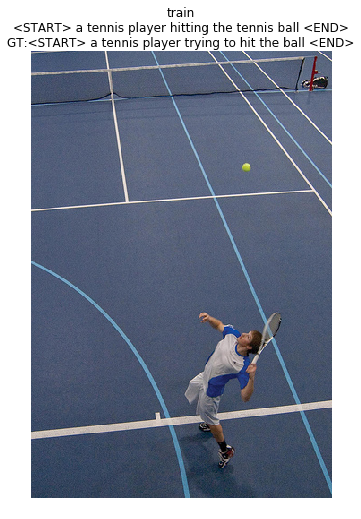

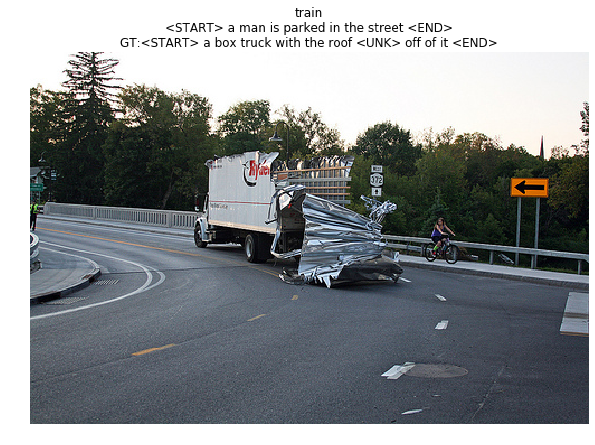

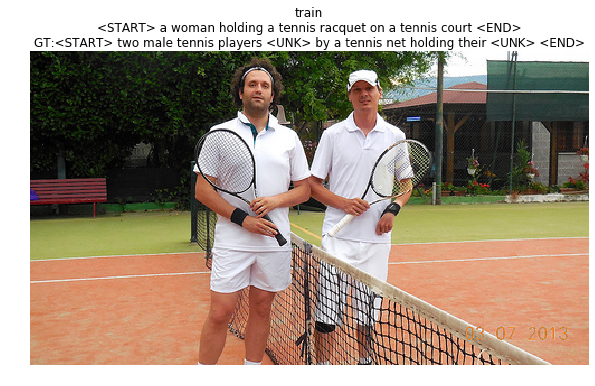

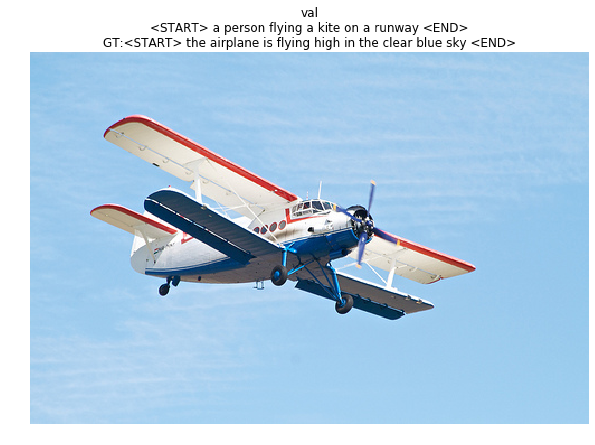

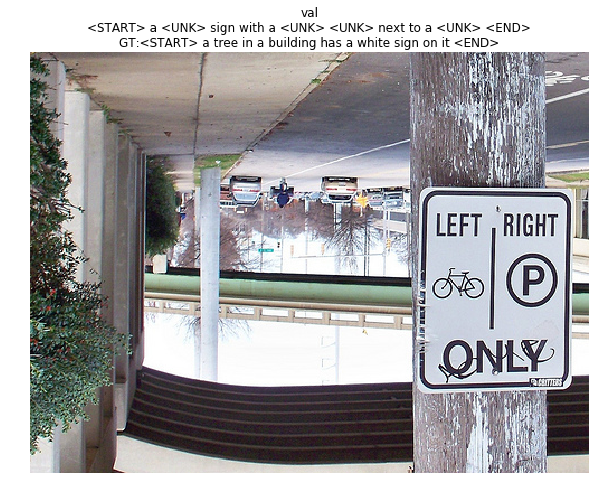

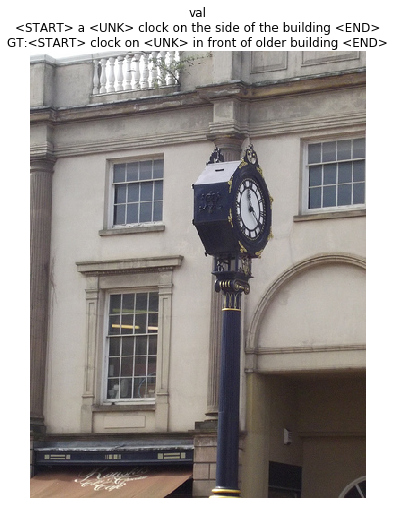

In [12]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(medium_data, split=split, batch_size=3)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()